In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score


Download and Load Data

In [55]:
data = 'https://raw.githubusercontent.com/theBoringEngineer/classifing_cybersecurity_intrusion_detection---Datatalks_midterm_project/refs/heads/main/data/raw/cybersecurity_intrusion_data.csv'

# !wget $data -O security_intrusion_dataset.csv

df = pd.read_csv('security_intrusion_dataset.csv')
df.head()

,session_id,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected
0,SID_00001,599,TCP,4,492.983263,DES,0.606818,1,Edge,0,1
1,SID_00002,472,TCP,3,1557.996461,DES,0.301569,0,Firefox,0,0
2,SID_00003,629,TCP,3,75.044262,DES,0.739164,2,Chrome,0,1
3,SID_00004,804,UDP,4,601.248835,DES,0.123267,0,Unknown,0,1
4,SID_00005,453,TCP,5,532.540888,AES,0.054874,1,Firefox,0,0


Data Preparation

In [56]:
# Standardize column names
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Handle missing values
print("\nMissing values (%):")
print((df.isnull().sum() / len(df) * 100))

df["encryption_used"] = df["encryption_used"].fillna("No_enc")



Missing values (%):
session_id              0.000000
network_packet_size     0.000000
protocol_type           0.000000
login_attempts          0.000000
session_duration        0.000000
encryption_used        20.614449
ip_reputation_score     0.000000
failed_logins           0.000000
browser_type            0.000000
unusual_time_access     0.000000
attack_detected         0.000000
dtype: float64


In [57]:
# Standardize categorical values
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.head().T

,0,1,2,3,4
session_id,sid_00001,sid_00002,sid_00003,sid_00004,sid_00005
network_packet_size,599,472,629,804,453
protocol_type,tcp,tcp,tcp,udp,tcp
login_attempts,4,3,3,4,5
session_duration,492.983263,1557.996461,75.044262,601.248835,532.540888
encryption_used,des,des,des,des,aes
ip_reputation_score,0.606818,0.301569,0.739164,0.123267,0.054874
failed_logins,1,0,2,0,1
browser_type,edge,firefox,chrome,unknown,firefox
unusual_time_access,0,0,0,0,0


# Setting up the validation framework

In [58]:
# Perform train/validation/test split
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

print(f"Train size: {len(df_train)}, Val size: {len(df_val)}, Test size: {len(df_test)}")


Train size: 5721, Val size: 1908, Test size: 1908


In [59]:

# Reset indices
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_full_train = df_full_train.reset_index(drop=True)


In [60]:
# Extract target variable
y_train = df_train.attack_detected.values
y_val = df_val.attack_detected.values
y_test = df_test.attack_detected.values
y_full_train = df_full_train.attack_detected.values

# Remove target from features
del df_train['attack_detected']
del df_val['attack_detected']
del df_test['attack_detected']

# Exploratory Data Analysis

In [62]:
# Check missing values
print("\nMissing values in full_train:")
print(df_full_train.isnull().sum())


Missing values in full_train:
session_id             0
network_packet_size    0
protocol_type          0
login_attempts         0
session_duration       0
encryption_used        0
ip_reputation_score    0
failed_logins          0
browser_type           0
unusual_time_access    0
attack_detected        0
dtype: int64


In [63]:
# Check target distribution
print("\nTarget variable distribution:")
print(df_full_train.attack_detected.value_counts(normalize=True))
print(f"\nAttack rate: {df_full_train.attack_detected.mean():.4f}")


Target variable distribution:
attack_detected
0    0.549744
1    0.450256
Name: proportion, dtype: float64

Attack rate: 0.4503


In [68]:
# Define numerical and categorical features
numerical = ['network_packet_size', 'login_attempts', 'session_duration',
             'ip_reputation_score', 'failed_logins', 'unusual_time_access']

categorical = [
    'protocol_type',
    'encryption_used',
    'browser_type'
]

print("\nCategorical features unique values:")
print(df_full_train[categorical].nunique())


Categorical features unique values:
protocol_type      3
encryption_used    3
browser_type       5
dtype: int64


# Feature Importance: Attack Rate and Risk Ratio

In [69]:
from IPython.display import display

global_attack = df_full_train.attack_detected.mean()

for c in categorical:
    print(f"\n{c}")
    df_group = df_full_train.groupby(c).attack_detected.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - global_attack
    df_group['risk'] = df_group['mean'] / global_attack
    display(df_group)



FEATURE IMPORTANCE ANALYSIS

protocol_type


,mean,count,diff,risk
protocol_type,,,,
icmp,0.415274,419,-0.034981,0.922308
tcp,0.452282,5302,0.002027,1.004501
udp,0.452306,1908,0.002050,1.004554



encryption_used


,mean,count,diff,risk
encryption_used,,,,
aes,0.435809,3770,-0.014447,0.967915
des,0.458859,2297,0.008604,1.019109
no_enc,0.472471,1562,0.022216,1.049340



browser_type


,mean,count,diff,risk
browser_type,,,,
chrome,0.428291,4079,-0.021964,0.951218
edge,0.436596,1175,-0.013660,0.969662
firefox,0.447301,1556,-0.002955,0.993437
safari,0.425000,400,-0.025256,0.943908
unknown,0.737470,419,0.287215,1.637892


Feature Importance: Mutual Information

In [70]:
from sklearn.metrics import mutual_info_score

def mutual_info_attack_score(series):
    return mutual_info_score(series, df_full_train.attack_detected)

mi = df_full_train[categorical].apply(mutual_info_attack_score)
print("\nMutual Information Scores:")
print(mi.sort_values(ascending=False))


Mutual Information Scores:
browser_type       0.009980
encryption_used    0.000457
protocol_type      0.000144
dtype: float64


# Feature Importance: Correlation


Correlation with target:
network_packet_size    0.011839
login_attempts         0.286342
session_duration       0.040014
ip_reputation_score    0.217295
failed_logins          0.361351
unusual_time_access    0.004483
dtype: float64


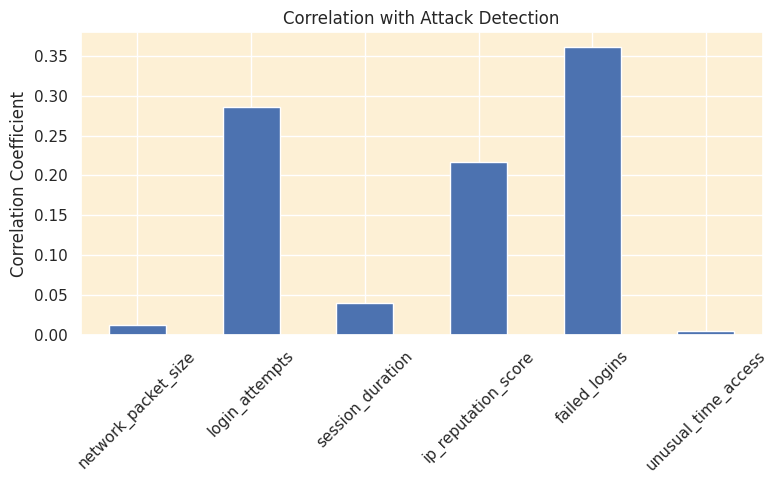

In [71]:
print("\nCorrelation with target:")
print(df_full_train[numerical].corrwith(df_full_train.attack_detected).abs())

# Visualize correlations
plt.figure(figsize=(8, 5))
corr_values = df_full_train[numerical].corrwith(df_full_train.attack_detected).abs()
corr_values.plot(kind='bar')
plt.title('Correlation with Attack Detection')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# One-hot Encoding

In [76]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler

dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

print(f"Training matrix shape: {X_train.shape}")
print(f"Validation matrix shape: {X_val.shape}")
print(f"Features: {dv.get_feature_names_out()}")

Training matrix shape: (5721, 17)
Validation matrix shape: (1908, 17)
Features: ['browser_type=chrome' 'browser_type=edge' 'browser_type=firefox'
 'browser_type=safari' 'browser_type=unknown' 'encryption_used=aes'
 'encryption_used=des' 'encryption_used=no_enc' 'failed_logins'
 'ip_reputation_score' 'login_attempts' 'network_packet_size'
 'protocol_type=icmp' 'protocol_type=tcp' 'protocol_type=udp'
 'session_duration' 'unusual_time_access']


# Normalization

In [77]:
# Scale the features for better convergence
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Model 1: Logistic Regression

In [79]:
model_lr = LogisticRegression(solver='lbfgs', max_iter=3000, random_state=1)
model_lr.fit(X_train, y_train)

# Predictions
y_pred_lr = model_lr.predict_proba(X_val)[:, 1]
attack_decision_lr = (y_pred_lr >= 0.5)

# Accuracy
accuracy_lr = (y_val == attack_decision_lr).mean()
print(f"\nLogistic Regression Validation Accuracy: {accuracy_lr:.4f}")

# ROC AUC
roc_auc_lr = roc_auc_score(y_val, y_pred_lr)
print(f"Logistic Regression ROC AUC: {roc_auc_lr:.4f}")

# Confusion Matrix
conf_matrix_lr = confusion_matrix(y_val, attack_decision_lr)
print("\nConfusion Matrix:")
print(conf_matrix_lr)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_val, attack_decision_lr))


Logistic Regression Validation Accuracy: 0.7442
Logistic Regression ROC AUC: 0.8059

Confusion Matrix:
[[846 192]
 [296 574]]

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.82      0.78      1038
           1       0.75      0.66      0.70       870

    accuracy                           0.74      1908
   macro avg       0.75      0.74      0.74      1908
weighted avg       0.74      0.74      0.74      1908



Model Interpretation - Logistic Regression

In [80]:

print(f"\nIntercept: {model_lr.intercept_[0]:.4f}")

# Feature coefficients
feature_importance_lr = dict(zip(dv.get_feature_names_out(), model_lr.coef_[0].round(3)))
print("\nFeature Coefficients:")
for feature, coef in sorted(feature_importance_lr.items(), key=lambda x: abs(x[1]), reverse=True)[:10]:
    print(f"{feature:40s}: {coef:7.3f}")


Intercept: -4.2519

Feature Coefficients:
ip_reputation_score                     :   3.331
browser_type=unknown                    :   1.427
failed_logins                           :   0.960
browser_type=safari                     :  -0.487
login_attempts                          :   0.427
browser_type=edge                       :  -0.373
browser_type=chrome                     :  -0.342
browser_type=firefox                    :  -0.250
encryption_used=no_enc                  :   0.149
encryption_used=aes                     :  -0.141


# Decision Tree

In [81]:

model_dt = DecisionTreeClassifier(max_depth=10, min_samples_split=10, random_state=1)
model_dt.fit(X_train, y_train)

# Predictions
y_pred_dt = model_dt.predict_proba(X_val)[:, 1]
attack_decision_dt = (y_pred_dt >= 0.5)

# Accuracy
accuracy_dt = (y_val == attack_decision_dt).mean()
print(f"\nDecision Tree Validation Accuracy: {accuracy_dt:.4f}")

# ROC AUC
roc_auc_dt = roc_auc_score(y_val, y_pred_dt)
print(f"Decision Tree ROC AUC: {roc_auc_dt:.4f}")

# Confusion Matrix
conf_matrix_dt = confusion_matrix(y_val, attack_decision_dt)
print("\nConfusion Matrix:")
print(conf_matrix_dt)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_val, attack_decision_dt))

# Feature Importance
feature_importance_dt = dict(zip(dv.get_feature_names_out(), model_dt.feature_importances_.round(3)))
print("\nTop 10 Feature Importances:")
for feature, importance in sorted(feature_importance_dt.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"{feature:40s}: {importance:7.3f}")


Decision Tree Validation Accuracy: 0.8889
Decision Tree ROC AUC: 0.8753

Confusion Matrix:
[[1023   15]
 [ 197  673]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.99      0.91      1038
           1       0.98      0.77      0.86       870

    accuracy                           0.89      1908
   macro avg       0.91      0.88      0.89      1908
weighted avg       0.90      0.89      0.89      1908


Top 10 Feature Importances:
failed_logins                           :   0.365
login_attempts                          :   0.333
ip_reputation_score                     :   0.226
browser_type=unknown                    :   0.045
session_duration                        :   0.012
network_packet_size                     :   0.009
unusual_time_access                     :   0.008
browser_type=edge                       :   0.002
encryption_used=des                     :   0.001
browser_type=chrome                     :   0.000


# Model 3: Random Forest

In [82]:
model_rf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=10,
                                   random_state=1, n_jobs=-1)
model_rf.fit(X_train, y_train)

# Predictions
y_pred_rf = model_rf.predict_proba(X_val)[:, 1]
attack_decision_rf = (y_pred_rf >= 0.5)

# Accuracy
accuracy_rf = (y_val == attack_decision_rf).mean()
print(f"\nRandom Forest Validation Accuracy: {accuracy_rf:.4f}")

# ROC AUC
roc_auc_rf = roc_auc_score(y_val, y_pred_rf)
print(f"Random Forest ROC AUC: {roc_auc_rf:.4f}")

# Confusion Matrix
conf_matrix_rf = confusion_matrix(y_val, attack_decision_rf)
print("\nConfusion Matrix:")
print(conf_matrix_rf)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_val, attack_decision_rf))

# Feature Importance
feature_importance_rf = dict(zip(dv.get_feature_names_out(), model_rf.feature_importances_.round(3)))
print("\nTop 10 Feature Importances:")
for feature, importance in sorted(feature_importance_rf.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"{feature:40s}: {importance:7.3f}")


Random Forest Validation Accuracy: 0.8947
Random Forest ROC AUC: 0.8901

Confusion Matrix:
[[1037    1]
 [ 200  670]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91      1038
           1       1.00      0.77      0.87       870

    accuracy                           0.89      1908
   macro avg       0.92      0.88      0.89      1908
weighted avg       0.91      0.89      0.89      1908


Top 10 Feature Importances:
failed_logins                           :   0.391
login_attempts                          :   0.300
ip_reputation_score                     :   0.201
browser_type=unknown                    :   0.038
session_duration                        :   0.023
network_packet_size                     :   0.022
browser_type=edge                       :   0.003
browser_type=firefox                    :   0.003
unusual_time_access                     :   0.003
browser_type=chrome                     :   0.002


# Model Comparison


               Model  Accuracy  ROC AUC
Logistic Regression  0.744235 0.805949
      Decision Tree  0.888889 0.875316
      Random Forest  0.894654 0.890147


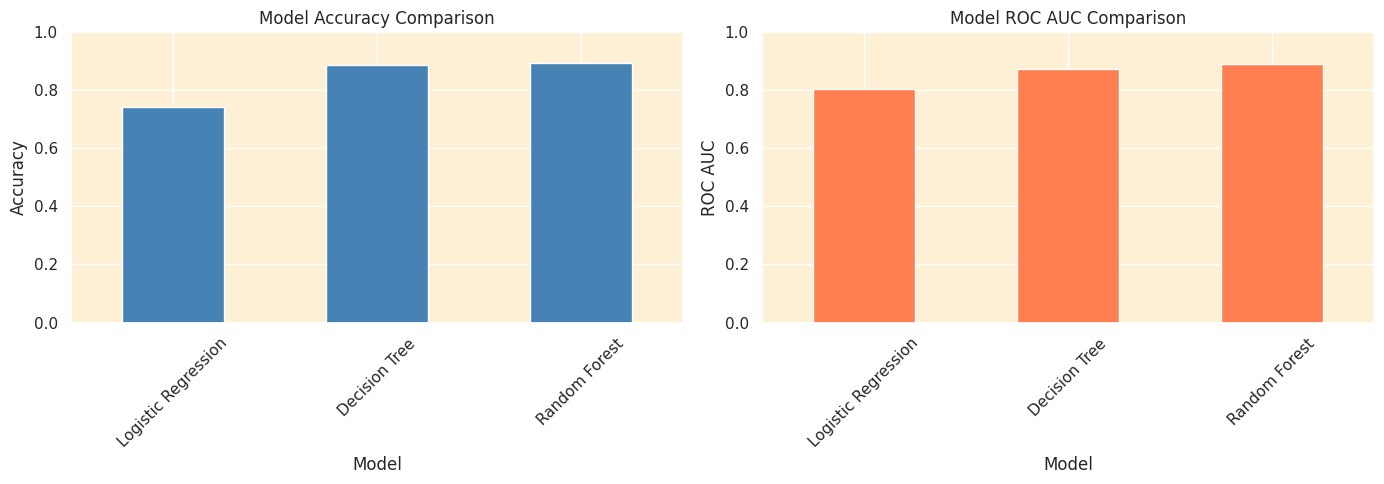

In [83]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest'],
    'Accuracy': [accuracy_lr, accuracy_dt, accuracy_rf],
    'ROC AUC': [roc_auc_lr, roc_auc_dt, roc_auc_rf]
})

print("\n", results.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

results.plot(x='Model', y='Accuracy', kind='bar', ax=axes[0], legend=False, color='steelblue')
axes[0].set_title('Model Accuracy Comparison')
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim([0, 1])
axes[0].tick_params(axis='x', rotation=45)

results.plot(x='Model', y='ROC AUC', kind='bar', ax=axes[1], legend=False, color='coral')
axes[1].set_title('Model ROC AUC Comparison')
axes[1].set_ylabel('ROC AUC')
axes[1].set_ylim([0, 1])
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Using the Best Model - Train on Full Training Set

In [84]:
# Using Random Forest as final model (since it has the best performance)
dicts_full_train = df_full_train[categorical + numerical].to_dict(orient='records')

dv_final = DictVectorizer(sparse=False)
X_full_train = dv_final.fit_transform(dicts_full_train)

# Scale features
scaler_final = StandardScaler()
X_full_train_scaled = scaler_final.fit_transform(X_full_train)

# Train final model
model_final = RandomForestClassifier(n_estimators=100, max_depth=10,
                                      min_samples_split=10, random_state=1, n_jobs=-1)
model_final.fit(X_full_train_scaled, y_full_train)

# Test on test set
dicts_test = df_test[categorical + numerical].to_dict(orient='records')
X_test = dv_final.transform(dicts_test)
X_test_scaled = scaler_final.transform(X_test)

y_pred_test = model_final.predict_proba(X_test_scaled)[:, 1]
attack_decision_test = (y_pred_test >= 0.5)

# Final accuracy
test_accuracy = (attack_decision_test == y_test).mean()
test_roc_auc = roc_auc_score(y_test, y_pred_test)

print(f"\nFinal Test Accuracy: {test_accuracy:.4f}")
print(f"Final Test ROC AUC: {test_roc_auc:.4f}")

print("\nFinal Classification Report:")
print(classification_report(y_test, attack_decision_test))


Final Test Accuracy: 0.8831
Final Test ROC AUC: 0.8786

Final Classification Report:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91      1079
           1       1.00      0.73      0.84       829

    accuracy                           0.88      1908
   macro avg       0.91      0.87      0.88      1908
weighted avg       0.90      0.88      0.88      1908



# Making Predictions on Individual Sessions

In [85]:
# Take last session from test set
session = dicts_test[-1]
print("\nSession details:")
print(session)


Session details:
{'protocol_type': 'tcp', 'encryption_used': 'no_enc', 'browser_type': 'chrome', 'network_packet_size': 523, 'login_attempts': 2, 'session_duration': 792.1858054507553, 'ip_reputation_score': 0.1397912875259956, 'failed_logins': 4, 'unusual_time_access': 0}

Predicted attack probability: 0.9616
Actual label: 1
🚨 PREDICTION: ATTACK DETECTED

✓ Analysis complete!


In [86]:
X_session = dv_final.transform([session])
X_session_scaled = scaler_final.transform(X_session)
attack_probability = model_final.predict_proba(X_session_scaled)[0, 1]

print(f"\nPredicted attack probability: {attack_probability:.4f}")
print(f"Actual label: {y_test[-1]}")

if attack_probability >= 0.5:
    print("🚨 PREDICTION: ATTACK DETECTED")
else:
    print("✅ PREDICTION: NORMAL SESSION")

print("\n✓ Analysis complete!")


Predicted attack probability: 0.9616
Actual label: 1
🚨 PREDICTION: ATTACK DETECTED

✓ Analysis complete!
